In [1]:
import json
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import pandas as pd

In [2]:
def load_expert_results(expert_name):
  result_all_runs = []
  for run_number in range(1,6):
    file_name = f"/content/drive/MyDrive/Binary_classification_using_LLMs/Mixture of Experts/Results/{expert_name}_Run{run_number}.json"
    with open(file_name, 'r') as file:
      results = json.load(file)
    print(f"Results loaded from {file_name}")
    # result_all_runs[f"Run{run_number}"] = results
    result_all_runs.append(results)
  return result_all_runs

# Without caution


In [3]:
import json
from tqdm import tqdm
from collections import Counter
import random # Imported for the dummy function

# Define class mappings
class_mapping = {"normal": 0, "abnormal": 1}
reverse_class_mapping = {v: k for k, v in class_mapping.items()}

# # This is a placeholder. Replace with your actual data loading logic.
# def load_expert_results(expert_name):
#     """Generates dummy prediction data for 5 runs."""
#     runs = []
#     predictions = ["normal", "abnormal"]
#     for _ in range(5):
#         run_data = {
#             "image1.jpg": {"expectation": "normal", "prediction": random.choice(predictions)},
#             "image2.jpg": {"expectation": "abnormal", "prediction": random.choice(predictions)},
#             "image3.jpg": {"expectation": "normal", "prediction": random.choice(predictions)},
#             "image4.jpg": {"expectation": "abnormal", "prediction": random.choice(predictions)},
#         }
#         runs.append(run_data)
#     return runs

# Your expert list and data loading
expert_list = ['resnet50_pretrained_cosine', 'resnet50_pretrained_one', 'resnet50_pretrained_euclidean', "resnet50_pretrained_inf","resnet50_pretrained_-inf"]

all_expert_5_runs_results = {
    expert: load_expert_results(expert) for expert in expert_list
}

# Function to extract the "output" value from the prediction string
def extract_output(prediction):
    if isinstance(prediction, str):
        return prediction.strip().lower()
    elif isinstance(prediction, dict):
        return prediction.get("output", "").strip().lower()
    else:
        return ""

def get_run_wise_majority_vote(all_expert_results):
    """
    Calculates detailed predictions for each run, segregated.

    Args:
        all_expert_results: A dictionary containing the results from all experts.

    Returns:
        A dictionary where each key is a run number (e.g., "run_1") and the
        value is another dictionary containing the run's image predictions.
    """
    if not all_expert_results:
        return {}

    run_wise_final_predictions = {}
    sample_expert = next(iter(all_expert_results.values()))
    num_runs = len(sample_expert)
    all_images = list(sample_expert[0].keys())

    # Iterate through each run
    for run_idx in range(num_runs):
        predictions_for_this_run = {}
        # Iterate through each image for the current run
        for img in tqdm(all_images, desc=f"Processing Run {run_idx + 1}"):
            image_results_for_run = {}
            run_votes = []

            # Collect predictions from all experts for this specific run and image
            for expert_name, expert_runs in all_expert_results.items():
                # Get the data for the current run
                run_data = expert_runs[run_idx]
                if img in run_data:
                    prediction_data = run_data[img]
                    pred_class = extract_output(prediction_data["prediction"])

                    # Add the actual class to the results (only needs to be done once per image)
                    if "actual_class" not in image_results_for_run:
                        actual_class = prediction_data["expectation"].lower()
                        image_results_for_run["actual_class"] = actual_class

                    if pred_class in class_mapping:
                        # Store the individual expert's prediction for this run
                        image_results_for_run[expert_name] = pred_class
                        # Add the vote for the final majority calculation
                        run_votes.append(class_mapping[pred_class])

            # Determine the majority vote for this run among all experts
            if run_votes:
                final_vote_counts = Counter(run_votes)
                final_majority_label = final_vote_counts.most_common(1)[0][0]
                image_results_for_run["majority_voting_label"] = reverse_class_mapping[final_majority_label]

            predictions_for_this_run[img] = image_results_for_run

        run_wise_final_predictions[f"run_{run_idx + 1}"] = predictions_for_this_run

    return run_wise_final_predictions

# Get the final, run-wise segregated predictions
final_predictions = get_run_wise_majority_vote(all_expert_5_runs_results)

# # Print the final predictions in a readable, segregated format
# for run_name, run_predictions in final_predictions.items():
#     print(f"================== RESULTS FOR {run_name.upper()} ==================")
#     for img, predictions in run_predictions.items():
#         print(f"--- Predictions for: {img} ---")
#         print(json.dumps(predictions, indent=4))
#     print("\n")

Results loaded from /content/drive/MyDrive/Binary_classification_using_LLMs/Mixture of Experts/Results/resnet50_pretrained_cosine_Run1.json
Results loaded from /content/drive/MyDrive/Binary_classification_using_LLMs/Mixture of Experts/Results/resnet50_pretrained_cosine_Run2.json
Results loaded from /content/drive/MyDrive/Binary_classification_using_LLMs/Mixture of Experts/Results/resnet50_pretrained_cosine_Run3.json
Results loaded from /content/drive/MyDrive/Binary_classification_using_LLMs/Mixture of Experts/Results/resnet50_pretrained_cosine_Run4.json
Results loaded from /content/drive/MyDrive/Binary_classification_using_LLMs/Mixture of Experts/Results/resnet50_pretrained_cosine_Run5.json
Results loaded from /content/drive/MyDrive/Binary_classification_using_LLMs/Mixture of Experts/Results/resnet50_pretrained_one_Run1.json
Results loaded from /content/drive/MyDrive/Binary_classification_using_LLMs/Mixture of Experts/Results/resnet50_pretrained_one_Run2.json
Results loaded from /conte

Processing Run 5: 100%|██████████| 314/314 [00:00<00:00, 57601.97it/s]


In [4]:
final_predictions.keys()

dict_keys(['run_1', 'run_2', 'run_3', 'run_4', 'run_5'])

In [5]:
for run_name, run_predictions in final_predictions.items():
    print(f"================== RESULTS FOR {run_name.upper()} ==================")
    for img, predictions in run_predictions.items():
        print(f"--- Predictions for: {img} ---")
        print(json.dumps(predictions, indent=4))
        break
    print("\n")

================== RESULTS FOR RUN_1 ==================
--- Predictions for: /test/lesion/SMITA00214_W_RB2.jpeg ---
{
    "actual_class": "abnormal",
    "resnet50_pretrained_cosine": "abnormal",
    "resnet50_pretrained_one": "abnormal",
    "resnet50_pretrained_euclidean": "abnormal",
    "resnet50_pretrained_inf": "abnormal",
    "resnet50_pretrained_-inf": "abnormal",
    "majority_voting_label": "abnormal"
}


================== RESULTS FOR RUN_2 ==================
--- Predictions for: /test/lesion/SMITA00214_W_RB2.jpeg ---
{
    "actual_class": "abnormal",
    "resnet50_pretrained_cosine": "abnormal",
    "resnet50_pretrained_one": "abnormal",
    "resnet50_pretrained_euclidean": "abnormal",
    "resnet50_pretrained_inf": "abnormal",
    "resnet50_pretrained_-inf": "abnormal",
    "majority_voting_label": "abnormal"
}


================== RESULTS FOR RUN_3 ==================
--- Predictions for: /test/lesion/SMITA00214_W_RB2.jpeg ---
{
    "actual_class": "abnormal",
    "resnet5

Results loaded from /content/drive/MyDrive/Binary_classification_using_LLMs/Mixture of Experts/Results/resnet50_pretrained_cosine_Run1.json
Results loaded from /content/drive/MyDrive/Binary_classification_using_LLMs/Mixture of Experts/Results/resnet50_pretrained_cosine_Run2.json
Results loaded from /content/drive/MyDrive/Binary_classification_using_LLMs/Mixture of Experts/Results/resnet50_pretrained_cosine_Run3.json
Results loaded from /content/drive/MyDrive/Binary_classification_using_LLMs/Mixture of Experts/Results/resnet50_pretrained_cosine_Run4.json
Results loaded from /content/drive/MyDrive/Binary_classification_using_LLMs/Mixture of Experts/Results/resnet50_pretrained_cosine_Run5.json
Results loaded from /content/drive/MyDrive/Binary_classification_using_LLMs/Mixture of Experts/Results/resnet50_pretrained_one_Run1.json
Results loaded from /content/drive/MyDrive/Binary_classification_using_LLMs/Mixture of Experts/Results/resnet50_pretrained_one_Run2.json
Results loaded from /conte

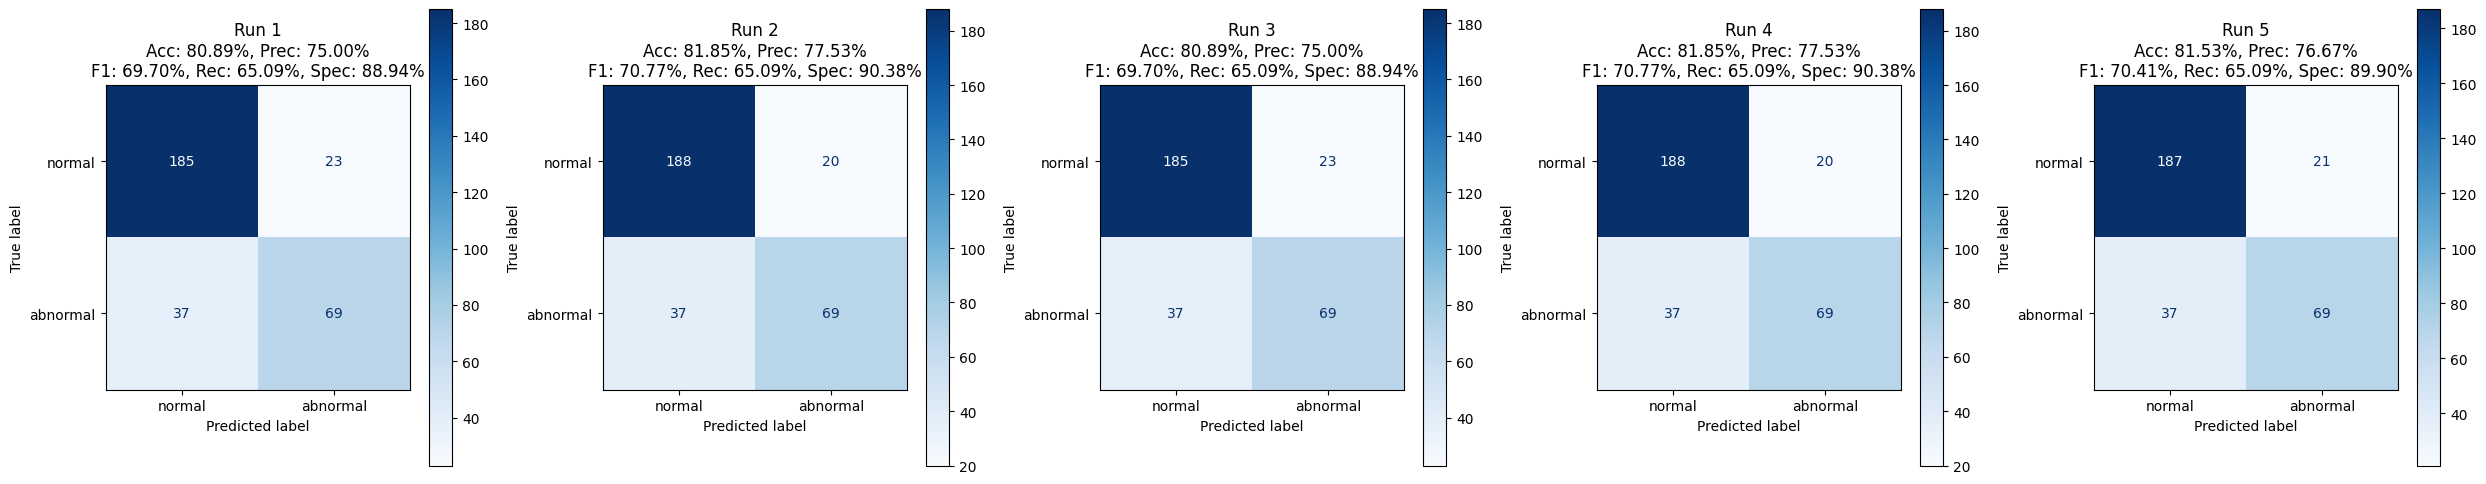


--- Summary of Metrics ---

Metrics for run_1:
  Accuracy: 80.89%
  Precision: 75.00%
  Recall (Sensitivity): 65.09%
  F1 Score: 69.70%
  Specificity: 88.94%

Metrics for run_2:
  Accuracy: 81.85%
  Precision: 77.53%
  Recall (Sensitivity): 65.09%
  F1 Score: 70.77%
  Specificity: 90.38%

Metrics for run_3:
  Accuracy: 80.89%
  Precision: 75.00%
  Recall (Sensitivity): 65.09%
  F1 Score: 69.70%
  Specificity: 88.94%

Metrics for run_4:
  Accuracy: 81.85%
  Precision: 77.53%
  Recall (Sensitivity): 65.09%
  F1 Score: 70.77%
  Specificity: 90.38%

Metrics for run_5:
  Accuracy: 81.53%
  Precision: 76.67%
  Recall (Sensitivity): 65.09%
  F1 Score: 70.41%
  Specificity: 89.90%


In [6]:
import json
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm
from collections import Counter
import random


# --- NEW Function to Calculate Metrics and Plot ---

def calculate_and_plot_metrics(final_predictions):
    """
    Calculates metrics and plots confusion matrices for majority votes from final_predictions.

    Args:
        final_predictions: A dictionary structured by run, then by image, containing
                           predictions and the actual class.
    """
    num_runs = len(final_predictions)
    if num_runs == 0:
        print("No data to process.")
        return

    # Prepare a figure for subplots (1 row, one plot per run)
    fig, axes = plt.subplots(1, num_runs, figsize=(5 * num_runs, 5))
    # If there's only one run, axes is not a list, so we make it one
    if num_runs == 1:
        axes = [axes]

    all_metrics = {}

    # Process results for each run
    for idx, (run_name, run_predictions) in enumerate(final_predictions.items()):
        actual = []
        prediction = []

        # Process each image in the run to get actual vs majority vote
        for img, data in run_predictions.items():
            if "actual_class" in data and "majority_voting_label" in data:
                actual.append(class_mapping[data["actual_class"]])
                prediction.append(class_mapping[data["majority_voting_label"]])

        # Compute metrics
        accuracy = accuracy_score(actual, prediction) * 100
        precision = precision_score(actual, prediction, average='binary', pos_label=class_mapping["abnormal"], zero_division=0) * 100
        recall = recall_score(actual, prediction, average='binary', pos_label=class_mapping["abnormal"], zero_division=0) * 100
        f1 = f1_score(actual, prediction, average='binary', pos_label=class_mapping["abnormal"], zero_division=0) * 100
        specificity = recall_score(actual, prediction, average='binary', pos_label=class_mapping["normal"], zero_division=0) * 100

        all_metrics[run_name] = {
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "specificity": specificity,
        }

        # Compute confusion matrix
        matrix = confusion_matrix(actual, prediction, labels=[0, 1])

        # Plot confusion matrix in a subplot
        ax = axes[idx]
        cm_display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=list(class_mapping.keys()))
        cm_display.plot(cmap=plt.cm.Blues, ax=ax)
        ax.set_title(
            f"{run_name.replace('_', ' ').title()}\n"
            f"Acc: {accuracy:.2f}%, Prec: {precision:.2f}%\n"
            f"F1: {f1:.2f}%, Rec: {recall:.2f}%, Spec: {specificity:.2f}%"
        )

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

    # Print metrics
    print("\n--- Summary of Metrics ---")
    for run_name, metric_values in all_metrics.items():
        print(f"\nMetrics for {run_name}:")
        print(f"  Accuracy: {metric_values['accuracy']:.2f}%")
        print(f"  Precision: {metric_values['precision']:.2f}%")
        print(f"  Recall (Sensitivity): {metric_values['recall']:.2f}%")
        print(f"  F1 Score: {metric_values['f1']:.2f}%")
        print(f"  Specificity: {metric_values['specificity']:.2f}%")

# --- Main Execution ---

# 1. Generate the data using the function from the previous step
expert_list = ['resnet50_pretrained_cosine', 'resnet50_pretrained_one', 'resnet50_pretrained_euclidean', "resnet50_pretrained_inf","resnet50_pretrained_-inf"]
all_expert_5_runs_results = {expert: load_expert_results(expert) for expert in expert_list}
# final_predictions_data = get_run_wise_majority_vote(all_expert_5_runs_results)

# 2. Call the new function to analyze and plot the results
calculate_and_plot_metrics(final_predictions)

Results loaded from /content/drive/MyDrive/Binary_classification_using_LLMs/Mixture of Experts/Results/resnet50_pretrained_cosine_Run1.json
Results loaded from /content/drive/MyDrive/Binary_classification_using_LLMs/Mixture of Experts/Results/resnet50_pretrained_cosine_Run2.json
Results loaded from /content/drive/MyDrive/Binary_classification_using_LLMs/Mixture of Experts/Results/resnet50_pretrained_cosine_Run3.json
Results loaded from /content/drive/MyDrive/Binary_classification_using_LLMs/Mixture of Experts/Results/resnet50_pretrained_cosine_Run4.json
Results loaded from /content/drive/MyDrive/Binary_classification_using_LLMs/Mixture of Experts/Results/resnet50_pretrained_cosine_Run5.json
Results loaded from /content/drive/MyDrive/Binary_classification_using_LLMs/Mixture of Experts/Results/resnet50_pretrained_one_Run1.json
Results loaded from /content/drive/MyDrive/Binary_classification_using_LLMs/Mixture of Experts/Results/resnet50_pretrained_one_Run2.json
Results loaded from /conte

Processing Run 5: 100%|██████████| 314/314 [00:00<00:00, 137964.75it/s]



--- Metrics DataFrame with Summary Statistics ---
               accuracy_run1  accuracy_run2  accuracy_run3  accuracy_run4  \
Majority Vote          80.89          81.85          80.89          81.85   

               accuracy_run5  accuracy_Avg  accuracy_Var  accuracy_Std  \
Majority Vote          81.53          81.4          0.23          0.48   

              accuracy_Avg+/-Std  precision_run1  ...  specificity_Avg+/-Std  \
Majority Vote       81.40 ± 0.48            75.0  ...           89.71 ± 0.73   

               f1_run1  f1_run2  f1_run3  f1_run4  f1_run5  f1_Avg f1_Var  \
Majority Vote     69.7    70.77     69.7    70.77    70.41   70.27   0.29   

               f1_Std  f1_Avg+/-Std  
Majority Vote    0.54  70.27 ± 0.54  

[1 rows x 45 columns]


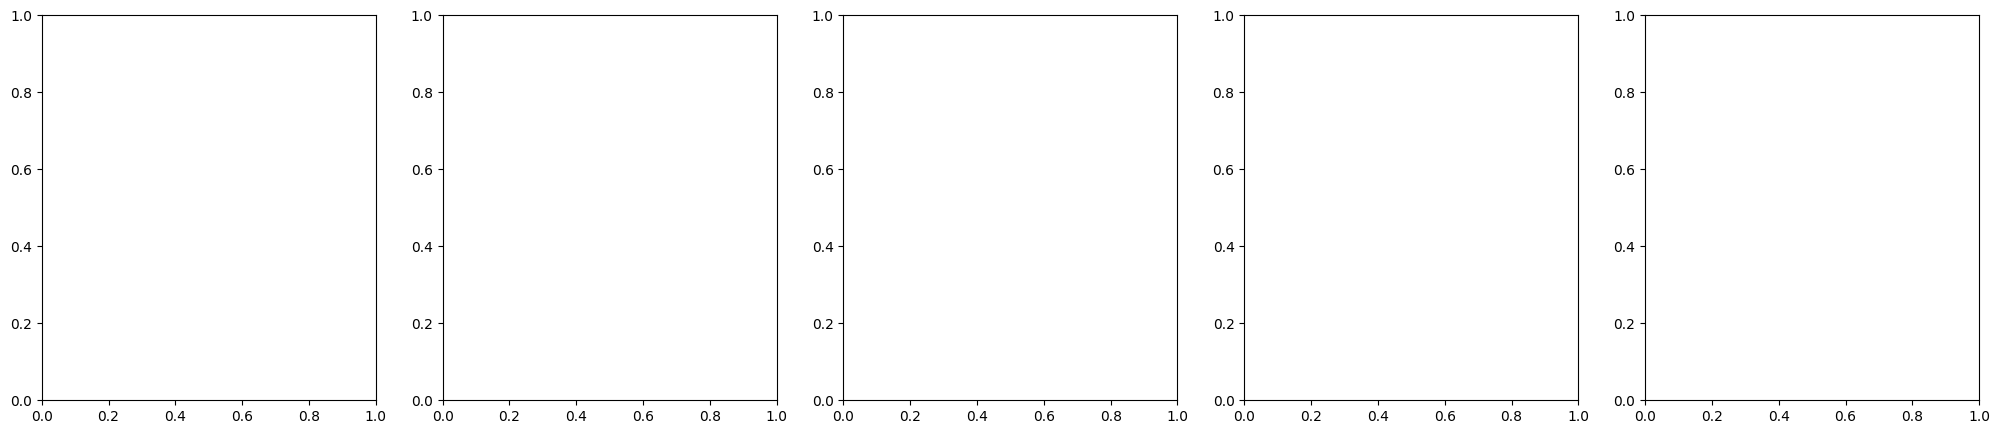

In [10]:
def calculate_plot_and_create_dataframe(final_predictions):
    """
    Calculates metrics, plots confusion matrices, and returns a summary DataFrame.

    Args:
        final_predictions: A dictionary structured by run, then by image.

    Returns:
        A pandas DataFrame with metrics, including summary statistics, across all runs.
    """
    num_runs = len(final_predictions)
    if num_runs == 0:
        print("No data to process.")
        return pd.DataFrame()

    fig, axes = plt.subplots(1, num_runs, figsize=(5 * num_runs, 5))
    if num_runs == 1:
        axes = [axes]

    all_metrics = {}

    for idx, (run_name, run_predictions) in enumerate(final_predictions.items()):
        actual, prediction = [], []
        for img, data in run_predictions.items():
            if "actual_class" in data and "majority_voting_label" in data:
                actual.append(class_mapping[data["actual_class"]])
                prediction.append(class_mapping[data["majority_voting_label"]])

        accuracy = accuracy_score(actual, prediction) * 100
        precision = precision_score(actual, prediction, average='binary', pos_label=class_mapping["abnormal"], zero_division=0) * 100
        recall = recall_score(actual, prediction, average='binary', pos_label=class_mapping["abnormal"], zero_division=0) * 100
        f1 = f1_score(actual, prediction, average='binary', pos_label=class_mapping["abnormal"], zero_division=0) * 100
        specificity = recall_score(actual, prediction, average='binary', pos_label=class_mapping["normal"], zero_division=0) * 100

        all_metrics[run_name] = {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1, "specificity": specificity}

        matrix = confusion_matrix(actual, prediction, labels=[0, 1])
        ax = axes[idx]
        cm_display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=list(class_mapping.keys()))
        cm_display.plot(cmap=plt.cm.Blues, ax=ax)
        ax.set_title(f"{run_name.replace('_', ' ').title()}\nAcc: {accuracy:.2f}%")

    plt.tight_layout()
    plt.show()

    # --- DataFrame Creation and Enhancement ---

    df_data = {}
    for run_name, metrics in all_metrics.items():
        run_num = run_name.split('_')[-1]
        for metric_name, value in metrics.items():
            df_data[f"{metric_name}_run{run_num}"] = value

    metrics_df = pd.DataFrame([df_data], index=['Majority Vote'])

    metric_order = ['accuracy', 'precision', 'recall', 'specificity', 'f1']
    final_column_order = []

    for metric in metric_order:
        run_cols = [f"{metric}_run{i+1}" for i in range(num_runs)]
        final_column_order.extend(run_cols)

        # Calculate summary stats for the current metric
        avg = metrics_df[run_cols].iloc[0].mean()
        var = metrics_df[run_cols].iloc[0].var()
        std = metrics_df[run_cols].iloc[0].std()

        # Add new stat columns to the DataFrame
        metrics_df[f'{metric}_Avg'] = avg
        metrics_df[f'{metric}_Var'] = var
        metrics_df[f'{metric}_Std'] = std
        metrics_df[f'{metric}_Avg+/-Std'] = f"{avg:.2f} ± {std:.2f}"

        # Add new stat column names to the final order
        final_column_order.extend([f'{metric}_Avg', f'{metric}_Var', f'{metric}_Std', f'{metric}_Avg+/-Std'])

    # Reorder the DataFrame with the new complete column list
    metrics_df = metrics_df[final_column_order]

    return metrics_df

# --- Main Execution ---

# 1. Generate the data
expert_list = ['resnet50_pretrained_cosine', 'resnet50_pretrained_one', 'resnet50_pretrained_euclidean', "resnet50_pretrained_inf","resnet50_pretrained_-inf"]
all_expert_5_runs_results = {expert: load_expert_results(expert) for expert in expert_list}
final_predictions_data = get_run_wise_majority_vote(all_expert_5_runs_results)

# 2. Call the function to plot and get the enhanced metrics DataFrame
metrics_dataframe = calculate_plot_and_create_dataframe(final_predictions_data)

# 3. Print the resulting DataFrame
print("\n--- Metrics DataFrame with Summary Statistics ---")
print(metrics_dataframe.round(2)) # Rounding for cleaner display

In [11]:
metrics_dataframe

,accuracy_run1,accuracy_run2,accuracy_run3,accuracy_run4,accuracy_run5,accuracy_Avg,accuracy_Var,accuracy_Std,accuracy_Avg+/-Std,precision_run1,...,specificity_Avg+/-Std,f1_run1,f1_run2,f1_run3,f1_run4,f1_run5,f1_Avg,f1_Var,f1_Std,f1_Avg+/-Std
Majority Vote,80.89172,81.847134,80.89172,81.847134,81.528662,81.401274,0.233275,0.482986,81.40 ± 0.48,75.0,...,89.71 ± 0.73,69.69697,70.769231,69.69697,70.769231,70.408163,70.268113,0.293565,0.541817,70.27 ± 0.54


In [12]:
metrics_dataframe.to_excel("/content/drive/MyDrive/Binary_classification_using_LLMs/Mixture of Experts/Results/Majority_voting_without_caution.xlsx")

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define class mappings
class_mapping = {"normal": 0, "abnormal": 1}

# Example results dictionary (replace with your actual data)
expert_list = ['resnet50_pretrained_cosine', 'resnet50_pretrained_one', 'resnet50_pretrained_euclidean', "resnet50_pretrained_inf","resnet50_pretrained_-inf", "Mixture of Experts(5_experts)",'resnet50_pretrained_random']

all_expert_5_runs_results = {
    "cosine": load_expert_results(expert_list[0]),
    "one": load_expert_results(expert_list[1]),
    "euclidean": load_expert_results(expert_list[2]),
    "inf": load_expert_results(expert_list[3]),
    "-inf": load_expert_results(expert_list[4]),
    "moe": load_expert_results(expert_list[5]),
    "random": load_expert_results(expert_list[6])
}

# Function to extract the "output" value from the prediction string
def extract_output(prediction):
    if isinstance(prediction, str):
        return prediction.strip().lower()
    elif isinstance(prediction, dict):
        return prediction.get("output", "").strip().lower()
    else:
        return ""

# Function to create a DataFrame with metrics for each expert and run
def create_metrics_dataframe(all_expert_5_runs_results, class_mapping):
    # Initialize a dictionary to store metrics for each expert
    expert_metrics = {}

    for expert_name, expert_runs in all_expert_5_runs_results.items():
        # Initialize a dictionary to store metrics for each run of the current expert
        run_metrics = {}

        for run_idx, run_data in enumerate(expert_runs):
            actual = []
            prediction = []
            unknown_classes = []

            for img, data in run_data.items():
                actual_class = data["expectation"].lower()
                pred_class = extract_output(data["prediction"])

                if pred_class not in class_mapping:
                    unknown_classes.append((img, actual_class, pred_class))
                    continue
                else:
                    pred_label = class_mapping[pred_class]
                    prediction.append(pred_label)
                    actual_label = class_mapping[actual_class]
                    actual.append(actual_label)

            # Compute metrics
            accuracy = accuracy_score(actual, prediction) * 100
            precision = precision_score(actual, prediction, average='binary', pos_label=class_mapping["abnormal"], zero_division=0) * 100
            recall = recall_score(actual, prediction, average='binary', pos_label=class_mapping["abnormal"], zero_division=0) * 100
            f1 = f1_score(actual, prediction, average='binary', pos_label=class_mapping["abnormal"], zero_division=0) * 100
            specificity = recall_score(actual, prediction, average='binary', pos_label=class_mapping["normal"], zero_division=0) * 100

            # Store metrics for the current run
            # run_metrics[f"accuracy_run{run_idx + 1}"] = accuracy
            # run_metrics[f"precision_run{run_idx + 1}"] = precision
            # run_metrics[f"recall_run{run_idx + 1}"] = recall
            # run_metrics[f"f1_run{run_idx + 1}"] = f1
            # run_metrics[f"specificity_run{run_idx + 1}"] = specificity

            run_metrics[f"accuracy_run{run_idx + 1}"] = round(accuracy, 4)
            run_metrics[f"precision_run{run_idx + 1}"] = round(precision, 4)
            run_metrics[f"recall_run{run_idx + 1}"] = round(recall, 4)
            run_metrics[f"f1_run{run_idx + 1}"] = round(f1, 4)
            run_metrics[f"specificity_run{run_idx + 1}"] = round(specificity, 4)

        # Store metrics for the current expert
        expert_metrics[expert_name] = run_metrics

    # Convert the dictionary to a DataFrame
    metrics_df = pd.DataFrame.from_dict(expert_metrics, orient='index')
    column_order = ['accuracy_run1', 'accuracy_run2', 'accuracy_run3', 'accuracy_run4', 'accuracy_run5',
                'precision_run1', 'precision_run2', 'precision_run3', 'precision_run4', 'precision_run5',
                'recall_run1', 'recall_run2', 'recall_run3', 'recall_run4', 'recall_run5',
                'specificity_run1', 'specificity_run2', 'specificity_run3', 'specificity_run4', 'specificity_run5',
                'f1_run1', 'f1_run2', 'f1_run3', 'f1_run4', 'f1_run5']
    metrics_df = metrics_df.loc[:, column_order]
    return metrics_df

# Create the DataFrame
metrics_df = create_metrics_dataframe(all_expert_5_runs_results, class_mapping)
print(metrics_df)

Results loaded from /content/drive/MyDrive/Binary_classification_using_LLMs/Mixture of Experts/Results/resnet50_pretrained_cosine_Run1.json
Results loaded from /content/drive/MyDrive/Binary_classification_using_LLMs/Mixture of Experts/Results/resnet50_pretrained_cosine_Run2.json
Results loaded from /content/drive/MyDrive/Binary_classification_using_LLMs/Mixture of Experts/Results/resnet50_pretrained_cosine_Run3.json
Results loaded from /content/drive/MyDrive/Binary_classification_using_LLMs/Mixture of Experts/Results/resnet50_pretrained_cosine_Run4.json
Results loaded from /content/drive/MyDrive/Binary_classification_using_LLMs/Mixture of Experts/Results/resnet50_pretrained_cosine_Run5.json
Results loaded from /content/drive/MyDrive/Binary_classification_using_LLMs/Mixture of Experts/Results/resnet50_pretrained_one_Run1.json
Results loaded from /content/drive/MyDrive/Binary_classification_using_LLMs/Mixture of Experts/Results/resnet50_pretrained_one_Run2.json
Results loaded from /conte

In [ ]:
# metrics_df.to_csv("/content/drive/MyDrive/Binary_classification_using_LLMs/Mixture of Experts/Results/metrics_df.csv")
# metrics_df.to_excel("/content/drive/MyDrive/Binary_classification_using_LLMs/Mixture of Experts/Results/metrics_df.xlsx")
metrics_df

,accuracy_run1,accuracy_run2,accuracy_run3,accuracy_run4,accuracy_run5,precision_run1,precision_run2,precision_run3,precision_run4,precision_run5,...,specificity_run1,specificity_run2,specificity_run3,specificity_run4,specificity_run5,f1_run1,f1_run2,f1_run3,f1_run4,f1_run5
cosine,78.0255,78.6624,78.3439,79.6178,78.0255,69.0722,70.5263,69.7917,72.3404,69.0722,...,85.5769,86.5385,86.0577,87.5000,85.5769,66.0099,66.6667,66.3366,68.0000,66.0099
one,79.2994,81.2102,80.8917,80.5732,81.5287,71.5789,75.8242,74.4681,74.1935,76.0870,...,87.0192,89.4231,88.4615,88.4615,89.4231,67.6617,70.0508,70.0000,69.3467,70.7071
euclidean,81.8471,82.4841,81.5287,81.2102,81.2102,74.7475,75.7576,74.0000,74.2268,74.2268,...,87.9808,88.4615,87.5000,87.9808,87.9808,72.1951,73.1707,71.8447,70.9360,70.9360
inf,78.3439,78.3439,78.9809,78.0255,78.3439,70.6522,69.7917,71.7391,70.7865,70.6522,...,87.0192,86.0577,87.5000,87.5000,87.0192,65.6566,66.3366,66.6667,64.6154,65.6566
-inf,81.8471,80.5732,81.2102,81.5287,82.8025,74.2574,72.2772,72.8155,73.0769,76.5306,...,87.5000,86.5385,86.5385,86.5385,88.9423,72.4638,70.5314,71.7703,72.3810,73.5294
moe,78.9809,80.8917,80.2548,79.9363,80.2548,67.8571,70.9091,69.2982,69.7248,70.3704,...,82.6923,84.6154,83.1731,84.1346,84.6154,69.7248,72.2222,71.8182,70.6977,71.0280
random,78.9809,79.9363,79.6178,80.5732,77.3885,70.4082,73.1183,72.8261,74.7253,68.8172,...,86.0577,87.9808,87.9808,88.9423,86.0577,67.6471,68.3417,67.6768,69.0355,64.3216


In [ ]:
metrics_df.to_excel("/content/drive/MyDrive/Binary_classification_using_LLMs/Mixture of Experts/Results/MOE_without_caution.xlsx")

# With caution

Results loaded from /content/drive/MyDrive/Binary_classification_using_LLMs/Mixture of Experts/Results/resnet50_pretrained_cosine_with_caution_Run1.json
Results loaded from /content/drive/MyDrive/Binary_classification_using_LLMs/Mixture of Experts/Results/resnet50_pretrained_cosine_with_caution_Run2.json
Results loaded from /content/drive/MyDrive/Binary_classification_using_LLMs/Mixture of Experts/Results/resnet50_pretrained_cosine_with_caution_Run3.json
Results loaded from /content/drive/MyDrive/Binary_classification_using_LLMs/Mixture of Experts/Results/resnet50_pretrained_cosine_with_caution_Run4.json
Results loaded from /content/drive/MyDrive/Binary_classification_using_LLMs/Mixture of Experts/Results/resnet50_pretrained_cosine_with_caution_Run5.json
Results loaded from /content/drive/MyDrive/Binary_classification_using_LLMs/Mixture of Experts/Results/resnet50_pretrained_one_with_caution_Run1.json
Results loaded from /content/drive/MyDrive/Binary_classification_using_LLMs/Mixture o

Processing images for one_with_caution run 5: 100%|██████████| 314/314 [00:00<00:00, 49405.84it/s]
Processing images for euclidean_with_caution run 1: 100%|██████████| 314/314 [00:00<00:00, 236065.86it/s]
Processing images for euclidean_with_caution run 2: 100%|██████████| 314/314 [00:00<00:00, 427323.64it/s]
Processing images for euclidean_with_caution run 3: 100%|██████████| 314/314 [00:00<00:00, 227266.86it/s]
Processing images for euclidean_with_caution run 4: 100%|██████████| 314/314 [00:00<00:00, 68827.36it/s]
Processing images for euclidean_with_caution run 5: 100%|██████████| 314/314 [00:00<00:00, 125849.16it/s]
Processing images for moe_with_caution run 5: 100%|██████████| 314/314 [00:00<00:00, 195199.56it/s]


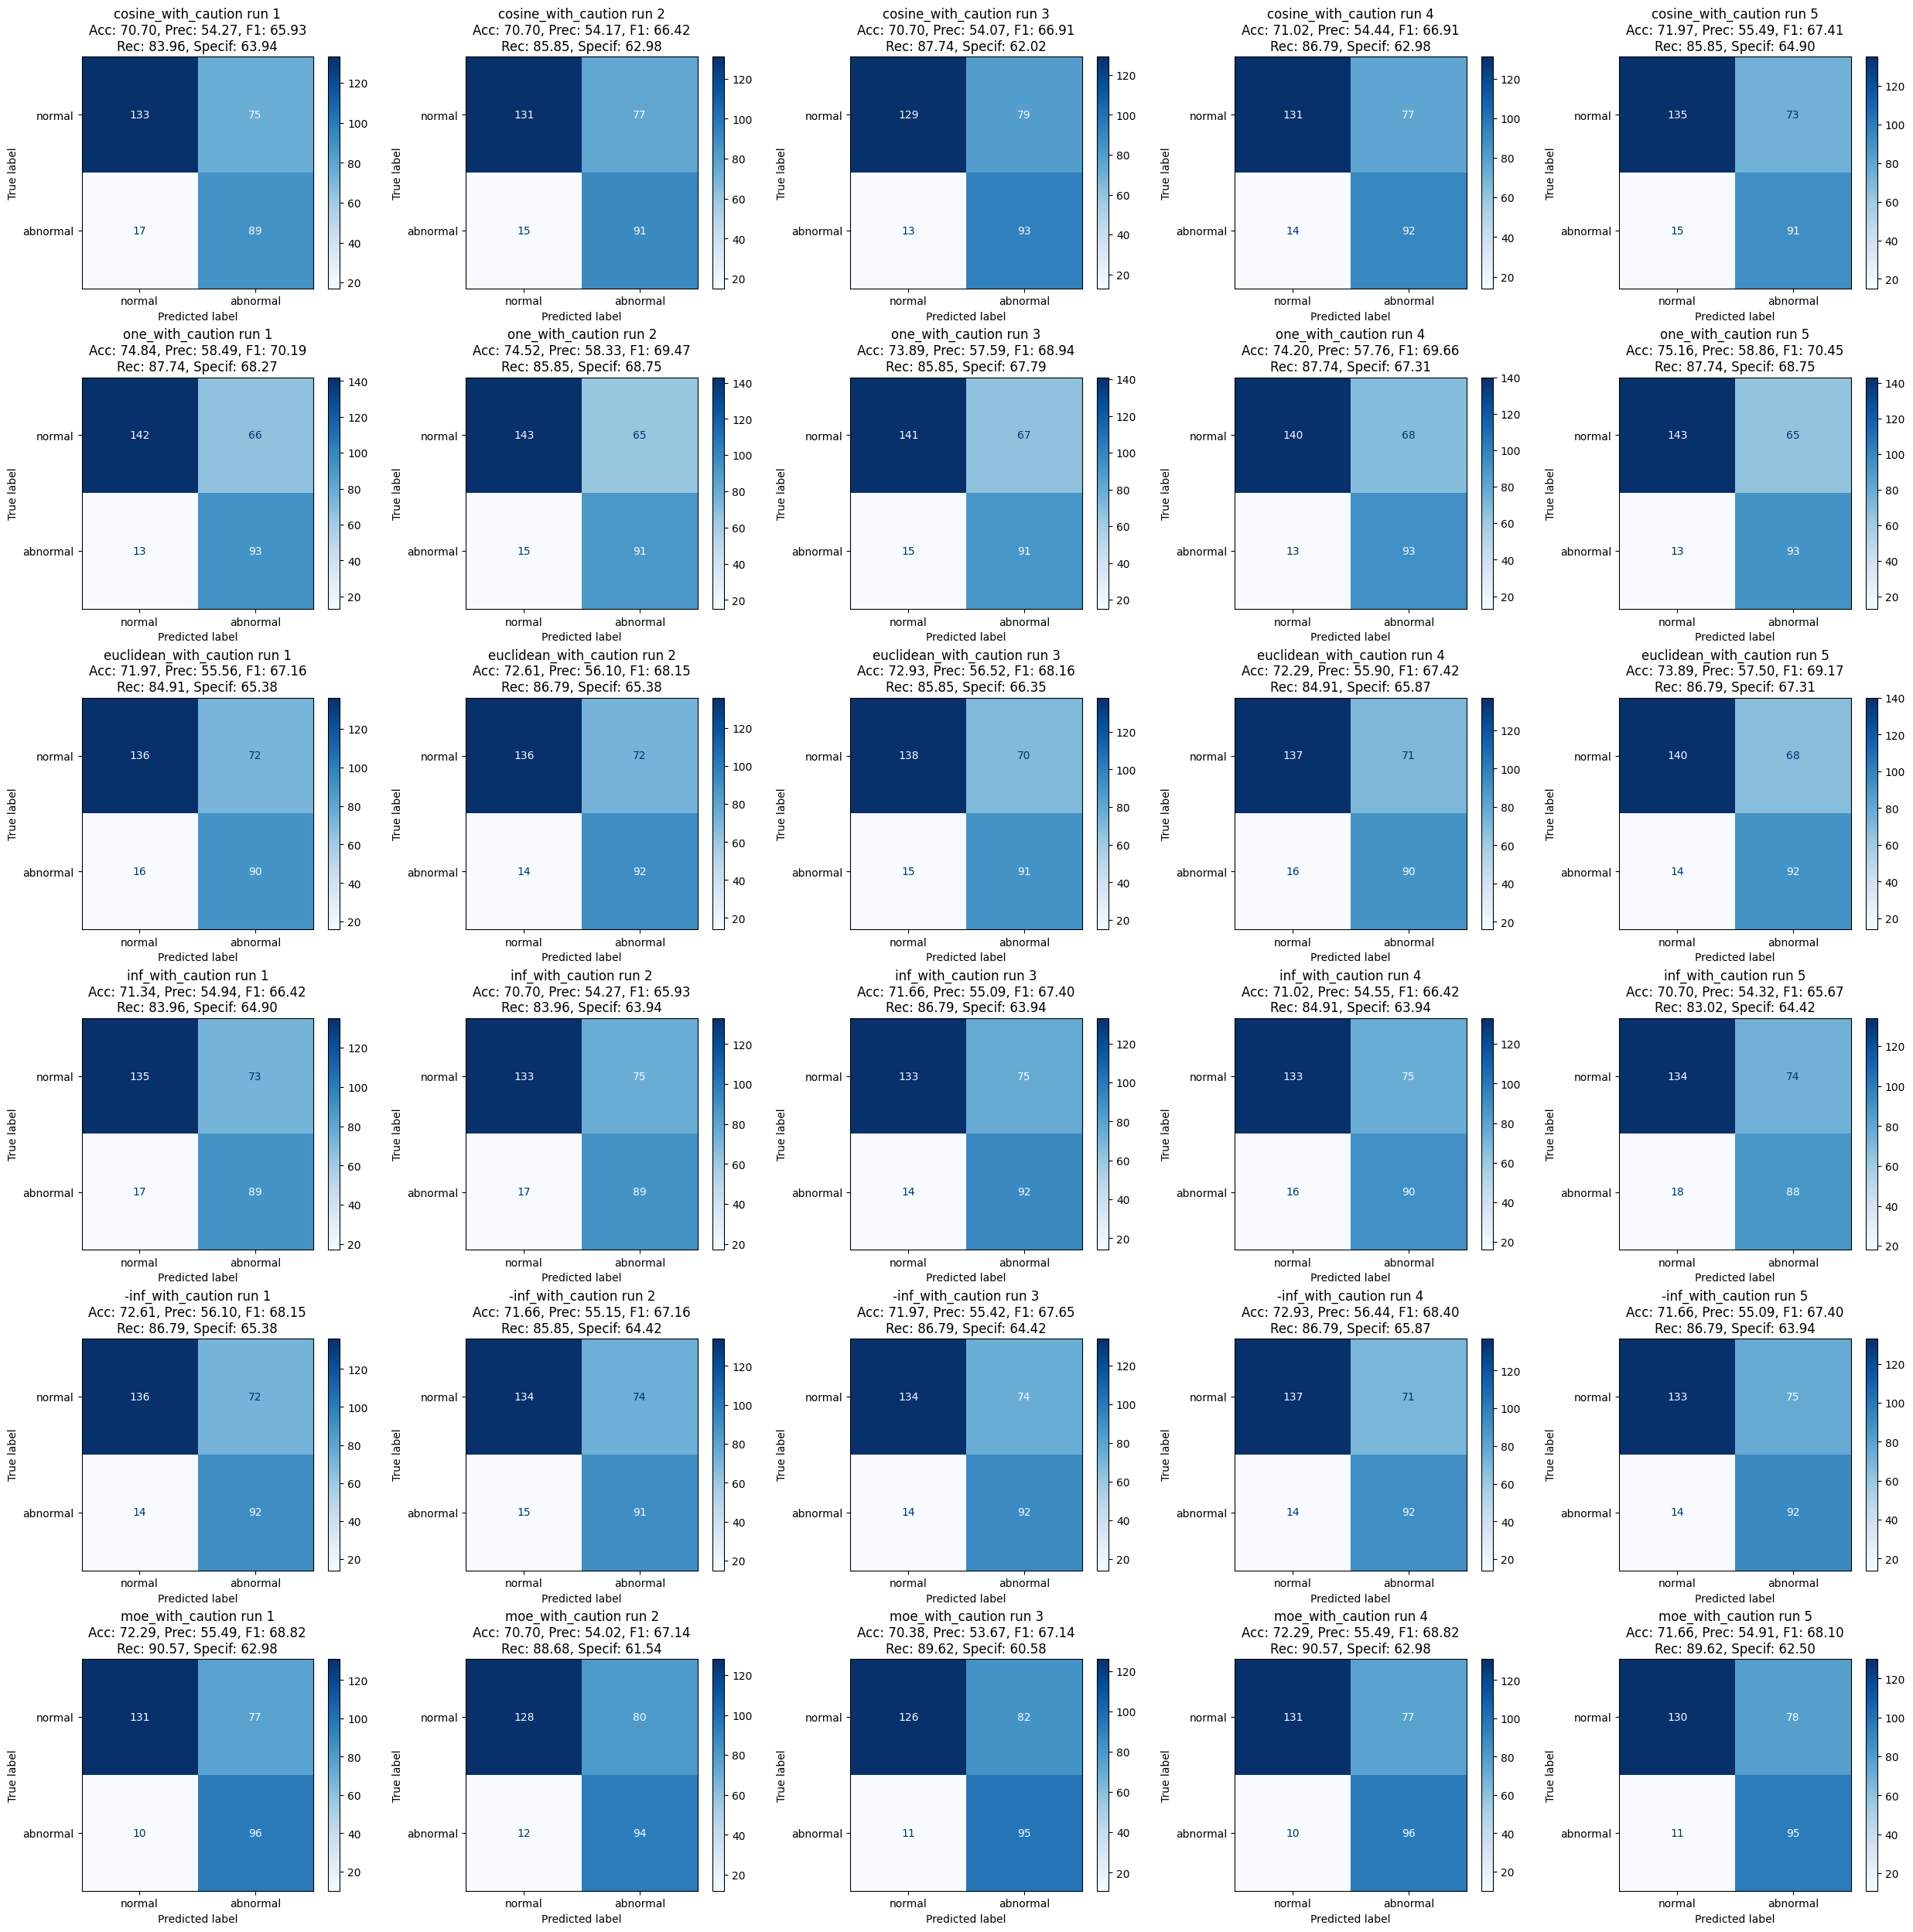


Metrics for cosine_with_caution_run1:
Accuracy: 70.70
Precision: 54.27
Recall: 83.96
F1 Score: 65.93
Specificity: 63.94

Metrics for cosine_with_caution_run2:
Accuracy: 70.70
Precision: 54.17
Recall: 85.85
F1 Score: 66.42
Specificity: 62.98

Metrics for cosine_with_caution_run3:
Accuracy: 70.70
Precision: 54.07
Recall: 87.74
F1 Score: 66.91
Specificity: 62.02

Metrics for cosine_with_caution_run4:
Accuracy: 71.02
Precision: 54.44
Recall: 86.79
F1 Score: 66.91
Specificity: 62.98

Metrics for cosine_with_caution_run5:
Accuracy: 71.97
Precision: 55.49
Recall: 85.85
F1 Score: 67.41
Specificity: 64.90

Metrics for one_with_caution_run1:
Accuracy: 74.84
Precision: 58.49
Recall: 87.74
F1 Score: 70.19
Specificity: 68.27

Metrics for one_with_caution_run2:
Accuracy: 74.52
Precision: 58.33
Recall: 85.85
F1 Score: 69.47
Specificity: 68.75

Metrics for one_with_caution_run3:
Accuracy: 73.89
Precision: 57.59
Recall: 85.85
F1 Score: 68.94
Specificity: 67.79

Metrics for one_with_caution_run4:
Accur

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from tqdm import tqdm

# Define class mappings
class_mapping = {"normal": 0, "abnormal": 1}

# Example results dictionary (replace with your actual data)
expert_list = ['resnet50_pretrained_cosine_with_caution', 'resnet50_pretrained_one_with_caution', 'resnet50_pretrained_euclidean_with_caution', "resnet50_pretrained_inf_with_caution","resnet50_pretrained_-inf_with_caution", "Mixture of Experts with caution(5_experts)"]

all_expert_5_runs_results = {
    "cosine_with_caution": load_expert_results(expert_list[0]),
    "one_with_caution": load_expert_results(expert_list[1]),
    "euclidean_with_caution": load_expert_results(expert_list[2]),
    "inf_with_caution": load_expert_results(expert_list[3]),
    "-inf_with_caution": load_expert_results(expert_list[4]),
    "moe_with_caution": load_expert_results(expert_list[5])
}

# Prepare a figure for subplots
num_experts = len(all_expert_5_runs_results)
num_runs = 5
fig, axes = plt.subplots(num_experts, num_runs, figsize=(25, 25))  # 5x5 grid

metrics = {}

# Function to extract the "output" value from the prediction string
def extract_output(prediction):
    # If the prediction is already a string (not JSON), return it directly
    if isinstance(prediction, str):
        return prediction.strip().lower()
    # If it's JSON, parse it and return the "output" value
    elif isinstance(prediction, dict):
        return prediction.get("output", "").strip().lower()
    else:
        return ""

# Process results for each expert and each run
for expert_idx, (expert_name, expert_runs) in enumerate(all_expert_5_runs_results.items()):
    for run_idx, run_data in enumerate(expert_runs):
        # Initialize lists for actual and prediction values
        actual = []
        prediction = []
        unknown_classes = []
        metrics[f"{expert_name}_run{run_idx+1}"] = {}

        # Process each image in the run
        for img, data in tqdm(run_data.items(), desc=f"Processing images for {expert_name} run {run_idx+1}"):
            actual_class = data["expectation"].lower()
            pred_class = extract_output(data["prediction"])

            if pred_class not in class_mapping:
                unknown_classes.append((img, actual_class, pred_class))
                print(f"Unknown class in prediction: {pred_class}")
                continue

            else:
                pred_label = class_mapping[pred_class]
                prediction.append(pred_label)
                actual_label = class_mapping[actual_class]
                actual.append(actual_label)

        # Compute metrics
        accuracy = accuracy_score(actual, prediction)*100
        precision = precision_score(actual, prediction, average='binary', pos_label=class_mapping["abnormal"], zero_division=0)*100
        recall = recall_score(actual, prediction, average='binary', pos_label=class_mapping["abnormal"], zero_division=0)*100
        f1 = f1_score(actual, prediction, average='binary', pos_label=class_mapping["abnormal"], zero_division=0)*100
        specificity = recall_score(actual, prediction, average='binary', pos_label=class_mapping["normal"], zero_division=0)*100

        metrics[f"{expert_name}_run{run_idx+1}"] = {
            "accuracy": accuracy,
            "precision": precision,
            "recall": recall,
            "f1": f1,
            "specificity": specificity,
            "unknown_classes": unknown_classes
        }

        # Compute confusion matrix
        matrix = confusion_matrix(actual, prediction, labels=[0, 1])  # Explicitly pass labels

        # Plot confusion matrix in a subplot
        ax = axes[expert_idx, run_idx]  # Calculate the position in the 5x5 grid
        cm_display = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=list(class_mapping.keys()))
        cm_display.plot(cmap=plt.cm.Blues, ax=ax)
        ax.set_title(
            f"{expert_name} run {run_idx+1}\n"
            f"Acc: {accuracy:.2f}, Prec: {precision:.2f}, F1: {f1:.2f}\n"
            f"Rec: {recall:.2f}, Specif: {specificity:.2f}"
        )

# Adjust layout and show the plot
plt.tight_layout()
# plt.savefig("/content/drive/MyDrive/Binary_classification_using_LLMs/Mixture of Experts/Results/moe_1st_experiment.jpeg", dpi=300)
plt.show()

# Print metrics
for run_name, metric_values in metrics.items():
    print(f"\nMetrics for {run_name}:")
    print(f"Accuracy: {metric_values['accuracy']:.2f}")
    print(f"Precision: {metric_values['precision']:.2f}")
    print(f"Recall: {metric_values['recall']:.2f}")
    print(f"F1 Score: {metric_values['f1']:.2f}")
    print(f"Specificity: {metric_values['specificity']:.2f}")
    if metric_values["unknown_classes"]:
        print(f"Unknown classes: {metric_values['unknown_classes']}")

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define class mappings
class_mapping = {"normal": 0, "abnormal": 1}

# Example results dictionary (replace with your actual data)
expert_list = ['resnet50_pretrained_cosine_with_caution', 'resnet50_pretrained_one_with_caution', 'resnet50_pretrained_euclidean_with_caution', "resnet50_pretrained_inf_with_caution","resnet50_pretrained_-inf_with_caution", "Mixture of Experts with caution(5_experts)"]

all_expert_5_runs_results = {
    "cosine_with_caution": load_expert_results(expert_list[0]),
    "one_with_caution": load_expert_results(expert_list[1]),
    "euclidean_with_caution": load_expert_results(expert_list[2]),
    "inf_with_caution": load_expert_results(expert_list[3]),
    "-inf_with_caution": load_expert_results(expert_list[4]),
    "moe_with_caution": load_expert_results(expert_list[5])
}

# Function to extract the "output" value from the prediction string
def extract_output(prediction):
    if isinstance(prediction, str):
        return prediction.strip().lower()
    elif isinstance(prediction, dict):
        return prediction.get("output", "").strip().lower()
    else:
        return ""

# Function to create a DataFrame with metrics for each expert and run
def create_metrics_dataframe(all_expert_5_runs_results, class_mapping):
    # Initialize a dictionary to store metrics for each expert
    expert_metrics = {}

    for expert_name, expert_runs in all_expert_5_runs_results.items():
        # Initialize a dictionary to store metrics for each run of the current expert
        run_metrics = {}

        for run_idx, run_data in enumerate(expert_runs):
            actual = []
            prediction = []
            unknown_classes = []

            for img, data in run_data.items():
                actual_class = data["expectation"].lower()
                pred_class = extract_output(data["prediction"])

                if pred_class not in class_mapping:
                    unknown_classes.append((img, actual_class, pred_class))
                    continue
                else:
                    pred_label = class_mapping[pred_class]
                    prediction.append(pred_label)
                    actual_label = class_mapping[actual_class]
                    actual.append(actual_label)

            # Compute metrics
            accuracy = accuracy_score(actual, prediction) * 100
            precision = precision_score(actual, prediction, average='binary', pos_label=class_mapping["abnormal"], zero_division=0) * 100
            recall = recall_score(actual, prediction, average='binary', pos_label=class_mapping["abnormal"], zero_division=0) * 100
            f1 = f1_score(actual, prediction, average='binary', pos_label=class_mapping["abnormal"], zero_division=0) * 100
            specificity = recall_score(actual, prediction, average='binary', pos_label=class_mapping["normal"], zero_division=0) * 100

            # Store metrics for the current run
            # run_metrics[f"accuracy_run{run_idx + 1}"] = accuracy
            # run_metrics[f"precision_run{run_idx + 1}"] = precision
            # run_metrics[f"recall_run{run_idx + 1}"] = recall
            # run_metrics[f"f1_run{run_idx + 1}"] = f1
            # run_metrics[f"specificity_run{run_idx + 1}"] = specificity

            run_metrics[f"accuracy_run{run_idx + 1}"] = round(accuracy, 4)
            run_metrics[f"precision_run{run_idx + 1}"] = round(precision, 4)
            run_metrics[f"recall_run{run_idx + 1}"] = round(recall, 4)
            run_metrics[f"f1_run{run_idx + 1}"] = round(f1, 4)
            run_metrics[f"specificity_run{run_idx + 1}"] = round(specificity, 4)

        # Store metrics for the current expert
        expert_metrics[expert_name] = run_metrics

    # Convert the dictionary to a DataFrame
    metrics_df = pd.DataFrame.from_dict(expert_metrics, orient='index')
    column_order = ['accuracy_run1', 'accuracy_run2', 'accuracy_run3', 'accuracy_run4', 'accuracy_run5',
                'precision_run1', 'precision_run2', 'precision_run3', 'precision_run4', 'precision_run5',
                'recall_run1', 'recall_run2', 'recall_run3', 'recall_run4', 'recall_run5',
                'specificity_run1', 'specificity_run2', 'specificity_run3', 'specificity_run4', 'specificity_run5',
                'f1_run1', 'f1_run2', 'f1_run3', 'f1_run4', 'f1_run5']
    metrics_df = metrics_df.loc[:, column_order]
    return metrics_df

# Create the DataFrame
metrics_df = create_metrics_dataframe(all_expert_5_runs_results, class_mapping)
print(metrics_df)

Results loaded from /content/drive/MyDrive/Binary_classification_using_LLMs/Mixture of Experts/Results/resnet50_pretrained_cosine_with_caution_Run1.json
Results loaded from /content/drive/MyDrive/Binary_classification_using_LLMs/Mixture of Experts/Results/resnet50_pretrained_cosine_with_caution_Run2.json
Results loaded from /content/drive/MyDrive/Binary_classification_using_LLMs/Mixture of Experts/Results/resnet50_pretrained_cosine_with_caution_Run3.json
Results loaded from /content/drive/MyDrive/Binary_classification_using_LLMs/Mixture of Experts/Results/resnet50_pretrained_cosine_with_caution_Run4.json
Results loaded from /content/drive/MyDrive/Binary_classification_using_LLMs/Mixture of Experts/Results/resnet50_pretrained_cosine_with_caution_Run5.json
Results loaded from /content/drive/MyDrive/Binary_classification_using_LLMs/Mixture of Experts/Results/resnet50_pretrained_one_with_caution_Run1.json
Results loaded from /content/drive/MyDrive/Binary_classification_using_LLMs/Mixture o

In [ ]:
# metrics_df.to_csv("/content/drive/MyDrive/Binary_classification_using_LLMs/Mixture of Experts/Results/metrics_df.csv")
# metrics_df.to_excel("/content/drive/MyDrive/Binary_classification_using_LLMs/Mixture of Experts/Results/metrics_df.xlsx")
metrics_df

,accuracy_run1,accuracy_run2,accuracy_run3,accuracy_run4,accuracy_run5,precision_run1,precision_run2,precision_run3,precision_run4,precision_run5,...,specificity_run1,specificity_run2,specificity_run3,specificity_run4,specificity_run5,f1_run1,f1_run2,f1_run3,f1_run4,f1_run5
cosine_with_caution,70.7006,70.7006,70.7006,71.0191,71.9745,54.2683,54.1667,54.0698,54.4379,55.4878,...,63.9423,62.9808,62.0192,62.9808,64.9038,65.9259,66.4234,66.9065,66.9091,67.4074
one_with_caution,74.8408,74.5223,73.8854,74.2038,75.1592,58.4906,58.3333,57.5949,57.7640,58.8608,...,68.2692,68.7500,67.7885,67.3077,68.7500,70.1887,69.4656,68.9394,69.6629,70.4545
euclidean_with_caution,71.9745,72.6115,72.9299,72.2930,73.8854,55.5556,56.0976,56.5217,55.9006,57.5000,...,65.3846,65.3846,66.3462,65.8654,67.3077,67.1642,68.1481,68.1648,67.4157,69.1729
inf_with_caution,71.3376,70.7006,71.6561,71.0191,70.7006,54.9383,54.2683,55.0898,54.5455,54.3210,...,64.9038,63.9423,63.9423,63.9423,64.4231,66.4179,65.9259,67.3993,66.4207,65.6716
-inf_with_caution,72.6115,71.6561,71.9745,72.9299,71.6561,56.0976,55.1515,55.4217,56.4417,55.0898,...,65.3846,64.4231,64.4231,65.8654,63.9423,68.1481,67.1587,67.6471,68.4015,67.3993
moe_with_caution,72.2930,70.7006,70.3822,72.2930,71.6561,55.4913,54.0230,53.6723,55.4913,54.9133,...,62.9808,61.5385,60.5769,62.9808,62.5000,68.8172,67.1429,67.1378,68.8172,68.1004


In [ ]:
metrics_df.to_excel("/content/drive/MyDrive/Binary_classification_using_LLMs/Mixture of Experts/Results/MOE_with_caution.xlsx")